# Hypothesis Test (ANOVA)
---

### Task
- Using ANOVA (analysis of variance) to test whether there are significant differences in bank performance(i.e. bank stock prices) among the consumer confidence groups.
- Each ANOVA will be performed separately based on different bank (JPMorgan Chase,Bank of America,Wells Fargo,Goldman Sachs,Citi Group)

### Null and Alternative Hypothesis

H0: μ1 = μ2 = μ3 (where μ1, μ2, μ3 represent the means of bank performance for low, moderate, and high consumer confidence groups, respectively)

HA: At least one mean is different from the others.

### Assumptions of Using ANOVA
- The samples are independent.
- Each sample is from a normally distributed population.
- The population standard deviations of the groups are all equal.

### Analysis
- The obtained F-statistic value indicates the magnitude of the observed differences in bank performance among the consumer confidence groups(High/Moderate/Low), which is greater than F critical value for all five tested banks.
- For instances, JPMorgan Chase has p-value as 0.00098, which is much smaller than 5% significant level.
- In summary, for all five tested banks, the null hypothesis is rejected and there are significant differences in bank performance(i.e. bank stock prices) across the consumer confidence groups.

### Extra Note:
- Using large sample size (monthly basis) to help to meet the assumptions of ANOVA

In [190]:
#Dependencies
import pandas as pd
import scipy.stats as stats
from scipy.stats import f

In [191]:
# Read the original CSV file of consumer sentiment index (monthly basis/Jan 2013 - Apr 2023)
monthly_csi = pd.read_csv("Resources/us_csi_original_monthly.csv")

#Rename the header of column and reset index
new_monthly_csi = monthly_csi.rename(columns = {"DATE" : "Date", "UMCSENT" : "Consumer Sentiment Index"})

# Read the original CSV file of all five banks' stock prices (monthly basis/Jan 2013 - Apr 2023) and rename the header of column
jpm_stock = pd.read_csv("Resources/jpm_stock_price.csv").rename(columns = {"Adj Close" : "Chase Adj Close"})
boa_stock = pd.read_csv("Resources/boa_stock_price.csv").rename(columns = {"Adj Close" : "BoA Adj Close"})
wf_stock = pd.read_csv("Resources/wf_stock_price.csv").rename(columns = {"Adj Close" : "WF Adj Close"})
gs_stock = pd.read_csv("Resources/gs_stock_price.csv").rename(columns = {"Adj Close" : "GS Adj Close"})
citi_stock = pd.read_csv("Resources/citi_stock_price.csv").rename(columns = {"Adj Close" : "Citi Adj Close"})

In [192]:
# Merge consumer sentiment index and all five banks' stock prices based on date and drop any unused columns
version1_df = pd.merge(new_monthly_csi, jpm_stock, how="left", on=["Date"]).drop(columns=['High', 'Volume', 'Open', 'Close', 'Low'])
version2_df= pd.merge(version1_df, boa_stock, how="left", on=["Date"]).drop(columns=['High', 'Volume', 'Open', 'Close', 'Low'])
version3_df= pd.merge(version2_df, wf_stock, how="left", on=["Date"]).drop(columns=['High', 'Volume', 'Open', 'Close', 'Low'])
version4_df= pd.merge(version3_df, gs_stock, how="left", on=["Date"]).drop(columns=['High', 'Volume', 'Open', 'Close', 'Low'])
complete_df= pd.merge(version4_df, citi_stock, how="left", on=["Date"]).drop(columns=['High', 'Volume', 'Open', 'Close', 'Low'])

# Display the final merged data frame
complete_df.head()

,Date,Consumer Sentiment Index,Chase Adj Close,BoA Adj Close,WF Adj Close,GS Adj Close,Citi Adj Close
0,2013-01-01,73.8,35.112534,9.481201,25.775806,123.101814,34.244678
1,2013-02-01,77.6,36.758884,9.405819,26.146143,124.683670,34.098484
2,2013-03-01,78.6,35.661839,10.210680,27.569729,122.926949,35.942738
3,2013-04-01,76.4,36.826508,10.319658,28.307592,122.024780,37.908882
4,2013-05-01,84.5,41.275848,11.451387,30.223087,135.399277,42.239227


In [193]:
# Generate descriptive statistics of consumer sentiment index and decide the boundaries of separating
# consumer confidence group
new_monthly_csi["Consumer Sentiment Index"].describe()

count    124.000000
mean      85.046774
std       12.847982
min       50.000000
25%       77.350000
50%       88.900000
75%       95.950000
max      101.400000
Name: Consumer Sentiment Index, dtype: float64

In [194]:
# Establish the bins for different groups of consumer sentiment index
csi_bins = [0, 85, 95, 105]
labels = ["Low CSI (<85)", "Moderate CSI (85-95)", "High CSI (95-105)"]

In [195]:
# Categorize the consumer sentiment index based on the bins
complete_df["CSI Ranking"] = pd.cut(complete_df["Consumer Sentiment Index"],
                                           csi_bins,labels=labels,include_lowest=True)
complete_df.head()

,Date,Consumer Sentiment Index,Chase Adj Close,BoA Adj Close,WF Adj Close,GS Adj Close,Citi Adj Close,CSI Ranking
0,2013-01-01,73.8,35.112534,9.481201,25.775806,123.101814,34.244678,Low CSI (<85)
1,2013-02-01,77.6,36.758884,9.405819,26.146143,124.683670,34.098484,Low CSI (<85)
2,2013-03-01,78.6,35.661839,10.210680,27.569729,122.926949,35.942738,Low CSI (<85)
3,2013-04-01,76.4,36.826508,10.319658,28.307592,122.024780,37.908882,Low CSI (<85)
4,2013-05-01,84.5,41.275848,11.451387,30.223087,135.399277,42.239227,Low CSI (<85)


In [196]:
# Define function for ANOVA
def anova(price,bank):
    
    low = complete_df[complete_df["CSI Ranking"] == "Low CSI (<85)"][price]
    moderate = complete_df[complete_df["CSI Ranking"] == "Moderate CSI (85-95)"][price]
    high = complete_df[complete_df["CSI Ranking"] == "High CSI (95-105)"][price]
    
    
    f_statistic, p_value = stats.f_oneway(low, moderate, high)
    print(f"{bank}: F statistic vaulue = {f_statistic} / P-value = {p_value}")
    
    
    # Set the significance level at 5%
    alpha = 0.05

    #Set up the degree of freedom and calculate the critical F-value for a two-tailed test
    # df1 = k-1 = 3-1 = 2
    # df2 = n-k = 124-3 = 121
    critical_f_value = f.ppf(1- alpha/2,2,121)
    
    if abs(f_statistic) > critical_f_value:
        print(f"Reject the null hypothesis. The result is statistically significant.")
    else:
        print(f"Fail to reject the null hypothesis. The result is not statistically significant.")
    print("--------------------------------------------------------------------------------------------")

In [197]:
#Print out the results of ANOVA per bank
anova("Chase Adj Close","JPMorgan Chase")
anova("BoA Adj Close","Bank of America")
anova("WF Adj Close","Wells Fargo")
anova("GS Adj Close","Goldman Sachs")
anova("Citi Adj Close","Citi Group")

JPMorgan Chase: F statistic vaulue = 7.336369871320204 / P-value = 0.0009833608159670933
Reject the null hypothesis. The result is statistically significant.
--------------------------------------------------------------------------------------------
Bank of America: F statistic vaulue = 8.495660429056539 / P-value = 0.00035276274494579825
Reject the null hypothesis. The result is statistically significant.
--------------------------------------------------------------------------------------------
Wells Fargo: F statistic vaulue = 23.295293230067482 / P-value = 2.763203374865016e-09
Reject the null hypothesis. The result is statistically significant.
--------------------------------------------------------------------------------------------
Goldman Sachs: F statistic vaulue = 10.154274986159066 / P-value = 8.381548996624196e-05
Reject the null hypothesis. The result is statistically significant.
-----------------------------------------------------------------------------------------

### Extra Note: Checking the normal distribution and homoscedasticity of bank stock price
- Example: JPMorgan stock price

In [203]:
# Check the homoscedasticity of JPMorgan stock price
from scipy.stats import bartlett

# Perform Bartlett's test
statistic, p_value = bartlett(chase_low, chase_moderate, chase_high)

# Print the test results
print("Test Statistic:", statistic)
print("P-value:", p_value)

Test Statistic: 27.874255292740354
P-value: 8.854873669745033e-07


<Axes: >

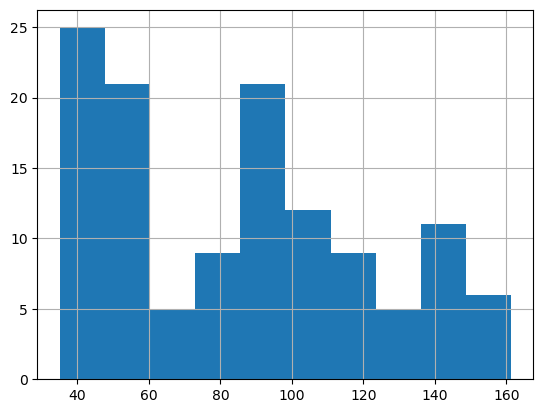

In [204]:
# Check the distribution of JPMorgan Stock Price
complete_df["Chase Adj Close"].hist()